In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add # Changed import statement

In [3]:
def readTextFile(path):
    with open(path) as f:
        caption = f.read()
    return caption

In [4]:
!pip install opendatasets
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/adityajn105/flickr8k")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mahesh2244
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k


100%|██████████| 1.04G/1.04G [00:13<00:00, 83.8MB/s]


In [5]:
captions = readTextFile('/content/flickr8k/captions.txt')

In [6]:
captions = captions.split('\n')[:-1]


In [7]:
captions[161]

'1042020065_fb3d3ba5ba.jpg,A boy in a green shirt is looking down at many inflatable boats .'

In [8]:
desc = {}

for x in captions:
    zyzz = x.split(',')
    img_name,img_captions= zyzz[0],zyzz[1]

    if desc.get(img_name) is None:
        desc[img_name] = []
    desc[img_name].append(img_captions)

In [9]:
desc['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
import cv2

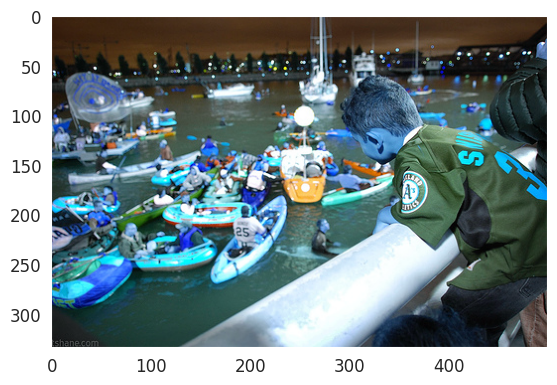

['A boy in a green shirt is looking down at many inflatable boats .',
 'A boy in a green shirt watches kayakers .',
 'A boy looks over a railing at the many boats and rafts below in the water .',
 'A young boy overlooking a crowd of inflatable boats .',
 'A young boy wearing a jersey looks down over a ledge at many boats in the water .']

In [11]:
path = '/content/flickr8k/Images/1042020065_fb3d3ba5ba.jpg'
plt.imshow(cv2.imread(path))
plt.show()
desc['1042020065_fb3d3ba5ba.jpg']

Data Cleaning
HERE

Do not remove stopwords
Do not stemming
Remove numbers, punctuations


In [12]:
import re


In [13]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ', sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1]
    sentence = ' '.join(sentence)
    return sentence

In [14]:
for key, caption_list in desc.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [15]:
desc['1042020065_fb3d3ba5ba.jpg']

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [16]:
with open('/content/flickr8k/description.txt','w') as f:
    f.write(str(desc))

In [17]:
import json

In [18]:
descriptions = None
with open('/content/flickr8k/description.txt') as f:
    descriptions = f.read()
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [19]:
print(type(descriptions))

<class 'dict'>


In [20]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [21]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size(unique words In Vocab) : %d"% len(vocab))

Vocab Size(unique words In Vocab) : 8258


In [22]:
vocab = set()
vocab.update(["hello", "apple"])
vocab.update(["hello"])
vocab.update(["hi"])
print(vocab)

{'hello', 'apple', 'hi'}


In [23]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [24]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words %d"%len(total_words))

Total Words 357792


In [25]:
len(total_words), type(total_words)

(357792, list)

In [26]:
import collections
counter = collections.Counter(total_words)
frq_cnt = dict(counter)
print(len(frq_cnt.keys()))

8258


In [27]:
sorted_freq_cnt = sorted(frq_cnt.items(), reverse = True, key=lambda x:x[1])

# filter
threshold =  10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [28]:
print(len(total_words)) # 1800 unique words filter, this is going to be new vocab size

1800


In [29]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [30]:
len(descriptions.keys()), len(descriptions.values())

(8092, 8092)

flickr8k  sample_data
Skipping, found downloaded files in "./flickr8k" (use force=True to force download)


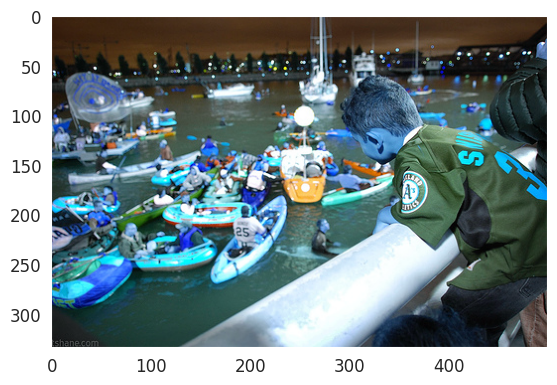

<class 'dict'>
Vocab Size(unique words In Vocab) : 8258
{'hello', 'apple', 'hi'}
Total Words 357792
8258
1800
captions.txt  description.txt  Images


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add
!dir
def readTextFile(path):
    with open(path) as f:
        caption = f.read()
    return caption
!pip install opendatasets
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/adityajn105/flickr8k")
captions = readTextFile('/content/flickr8k/captions.txt')
captions = captions.split('\n')[:-1]
captions[161]
desc = {}

for x in captions:
    zyzz = x.split(',')
    img_name,img_captions= zyzz[0],zyzz[1]

    if desc.get(img_name) is None:
        desc[img_name] = []
    desc[img_name].append(img_captions)
desc['1000268201_693b08cb0e.jpg']
import cv2
path = '/content/flickr8k/Images/1042020065_fb3d3ba5ba.jpg'
plt.imshow(cv2.imread(path))
plt.show()
desc['1042020065_fb3d3ba5ba.jpg']
import re
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ', sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1]
    sentence = ' '.join(sentence)
    return sentence
for key, caption_list in desc.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])
desc['1042020065_fb3d3ba5ba.jpg']
with open('/content/flickr8k/description.txt','w') as f:
    f.write(str(desc))
import json
descriptions = None
with open('/content/flickr8k/description.txt') as f:
    descriptions = f.read()
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)
print(type(descriptions))
descriptions.get('1042020065_fb3d3ba5ba.jpg')
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size(unique words In Vocab) : %d"% len(vocab))
vocab = set()
vocab.update(["hello", "apple"])
vocab.update(["hello"])
vocab.update(["hi"])
print(vocab)
descriptions.get('1042020065_fb3d3ba5ba.jpg')
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words %d"%len(total_words))
len(total_words), type(total_words)
import collections
counter = collections.Counter(total_words)
frq_cnt = dict(counter)
print(len(frq_cnt.keys()))
sorted_freq_cnt = sorted(frq_cnt.items(), reverse = True, key=lambda x:x[1])

# filter
threshold =  10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]
print(len(total_words)) # 1800 unique words filter, this is going to be new vocab size
descriptions.get('1042020065_fb3d3ba5ba.jpg')
len(descriptions.keys()), len(descriptions.values())

# Define text_preprocessing function
def text_preprocessing(data):
    # If data is a dictionary, assume it's the descriptions dictionary
    if isinstance(data, dict):
        df = pd.DataFrame(columns = ['image_id', 'caption'])
        for key, captions in data.items():
            for caption in captions:
                row = {'image_id': key, 'caption': caption}
                df = pd.concat([df, pd.DataFrame([row])], ignore_index = True)
    # If data is not a dictionary, assume it's already a dataframe
    elif isinstance(data, pd.DataFrame):
        df = data.copy()
    else:
        raise ValueError("Data must be a dictionary or a Pandas DataFrame")

    # Apply the clean_text function
    df['caption'] = df['caption'].apply(clean_text)
    return df

# Create a DataFrame from the descriptions dictionary before passing it to text_preprocessing
df = pd.DataFrame(columns = ['image_id', 'caption'])
for key, captions in descriptions.items():
    for caption in captions:
      row = {'image_id': key, 'caption': caption}
      df = pd.concat([df, pd.DataFrame([row])], ignore_index = True)

data = text_preprocessing(df)
captions = data['caption'].tolist()
captions[:10]
!ls /content/flickr8k

In [33]:
!ls /content/flickr8k

captions.txt  description.txt  Images


In [34]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image_id'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image_id'].isin(train_images)]
test = data[data['image_id'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[40, 1, 85, 168, 4, 112, 48, 383, 9, 379, 1, 25, 4990, 664]

In [35]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")


In [37]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        # Changed temp_df.image to temp_df.image_id to fix the error
        image = readImage(f"/content/flickr8k/Images/{temp_df.image_id[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

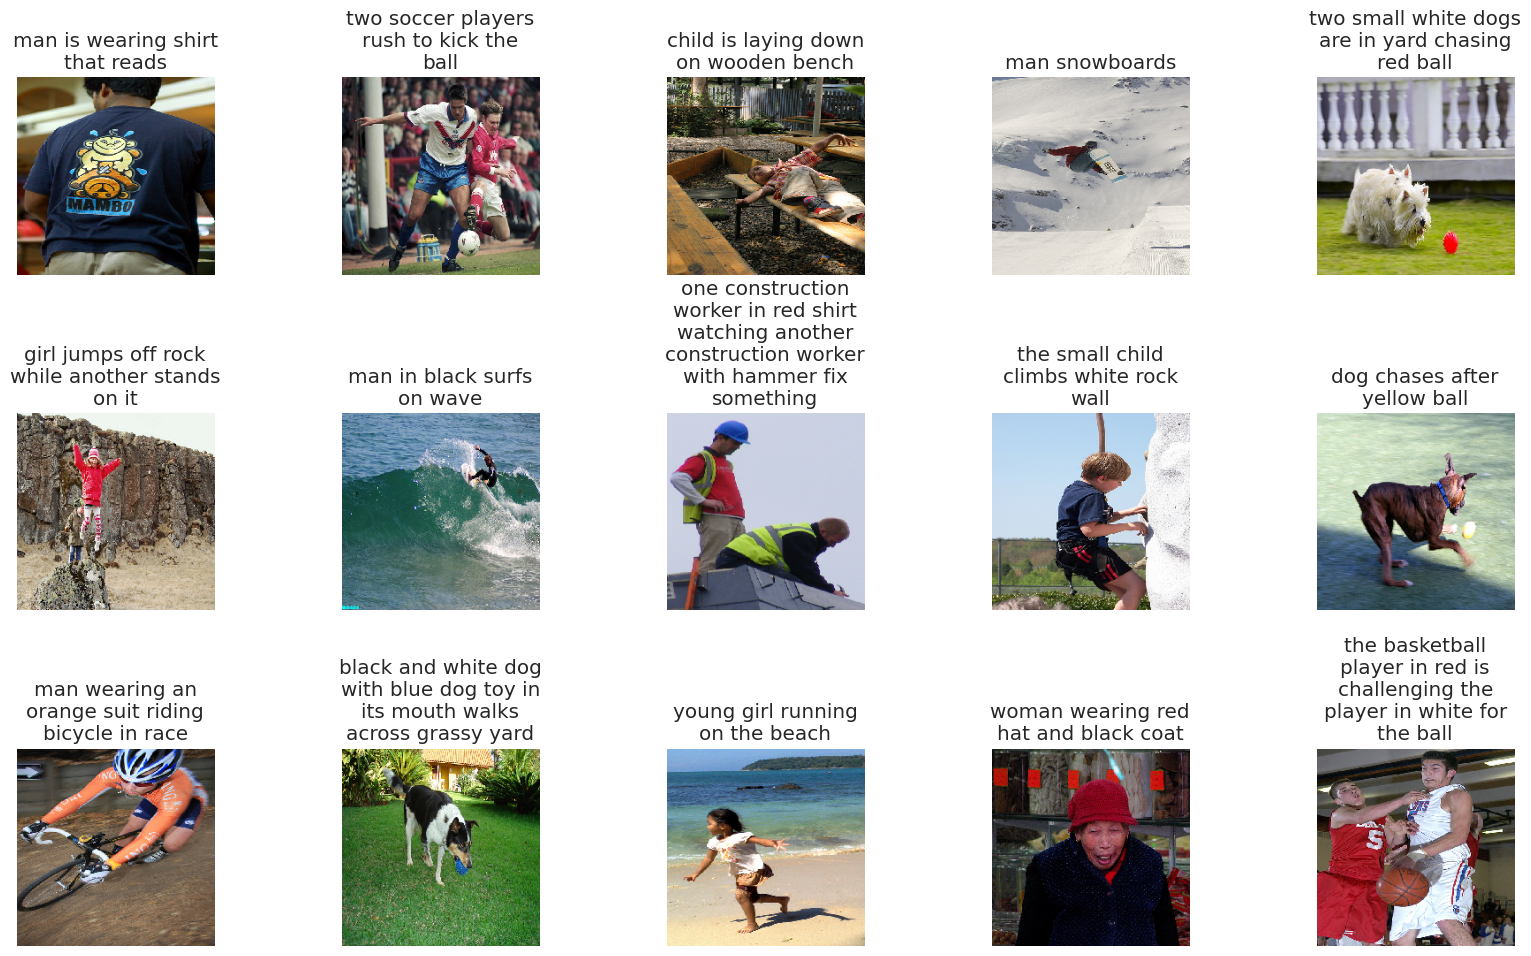

In [38]:
display_images(data.sample(15))

In [39]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = data['caption'].apply(lambda x: "startseq "+ x +" endseq")
    return data
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [40]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq caption endseq',
 'startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq']

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image_id'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image_id'].isin(train_images)]
test = data[data['image_id'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 42, 3, 87, 170, 6, 114, 50, 385, 11, 381, 3, 27, 4992, 666, 2]

In [42]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}


82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [43]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [44]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [45]:
from tensorflow.keras.utils import plot_model

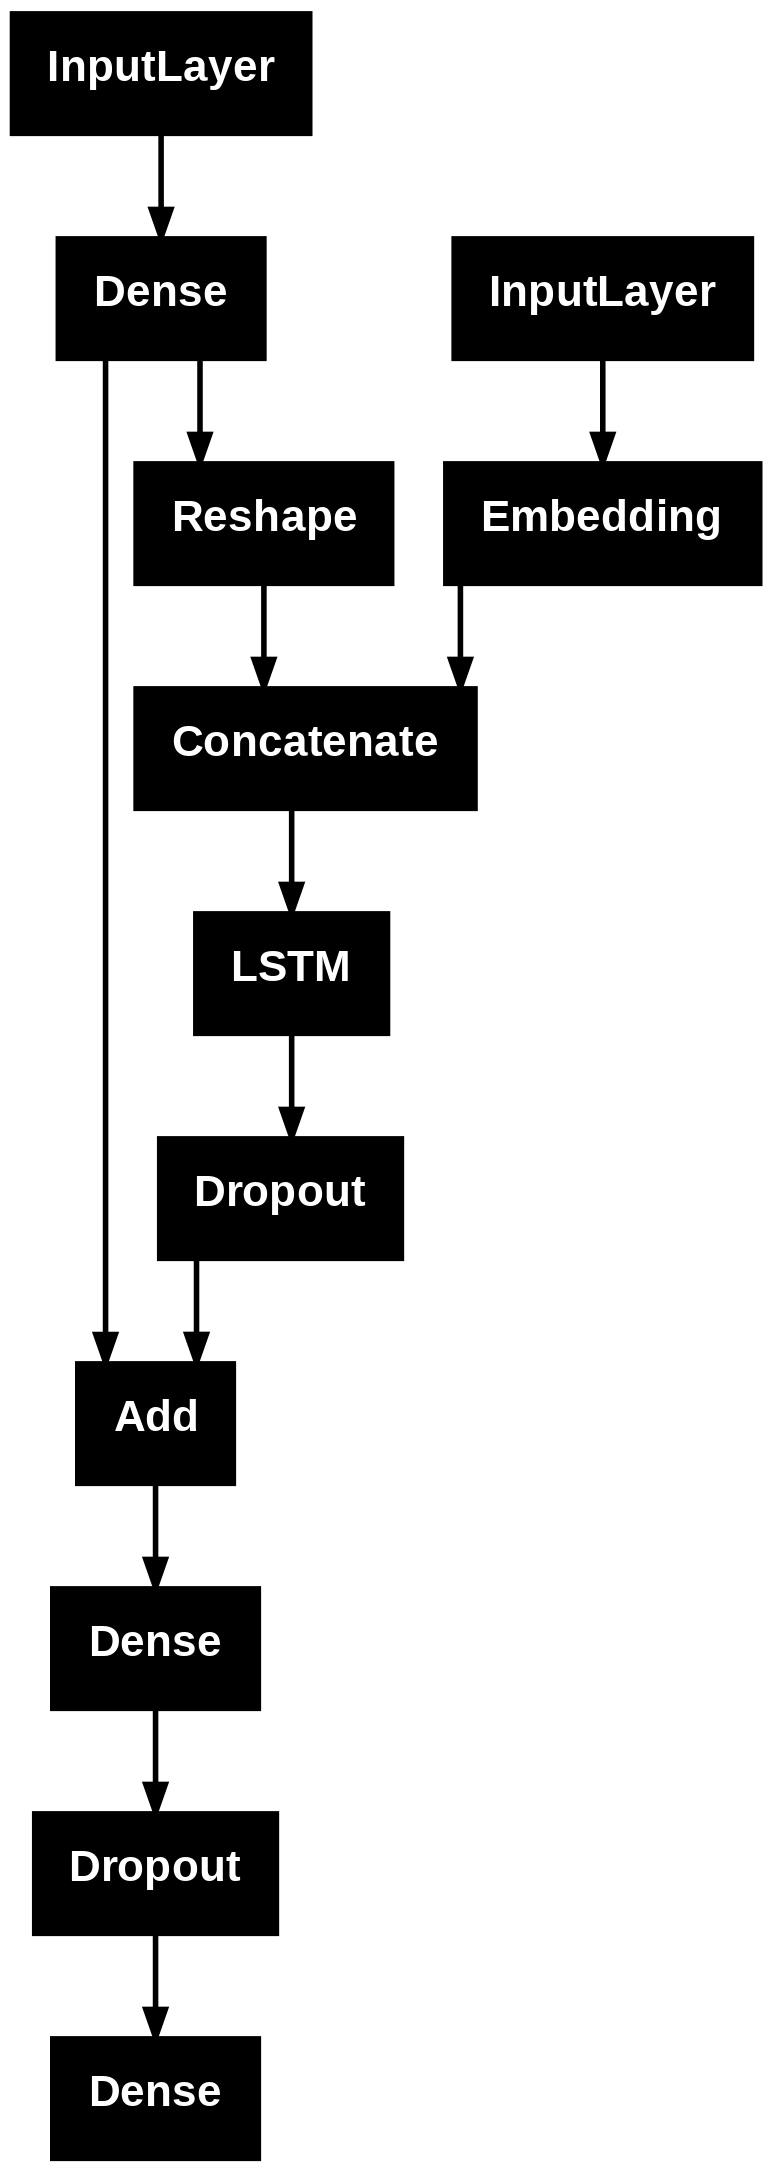

In [47]:
plot_model(caption_model)

In [46]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1920)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        491,776 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 31)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 31, 256)        │      2,114,816 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 256)        │              0 │ reshape[0][0],         │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8261)           │      1,065,669 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,230,469 (16.14 MB)

 Trainable params: 4,230,469 (16.14 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
train_generator = CustomDataGenerator(df=train,X_col='image_id',y_col='caption',batch_size=64,directory='/content/flickr8k/Images',
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image_id',y_col='caption',batch_size=64,directory='/content/flickr8k/Images',
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [49]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [50]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [51]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
          break
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [54]:
samples = test.sample(25)
samples.reset_index(drop=True,inplace=True)

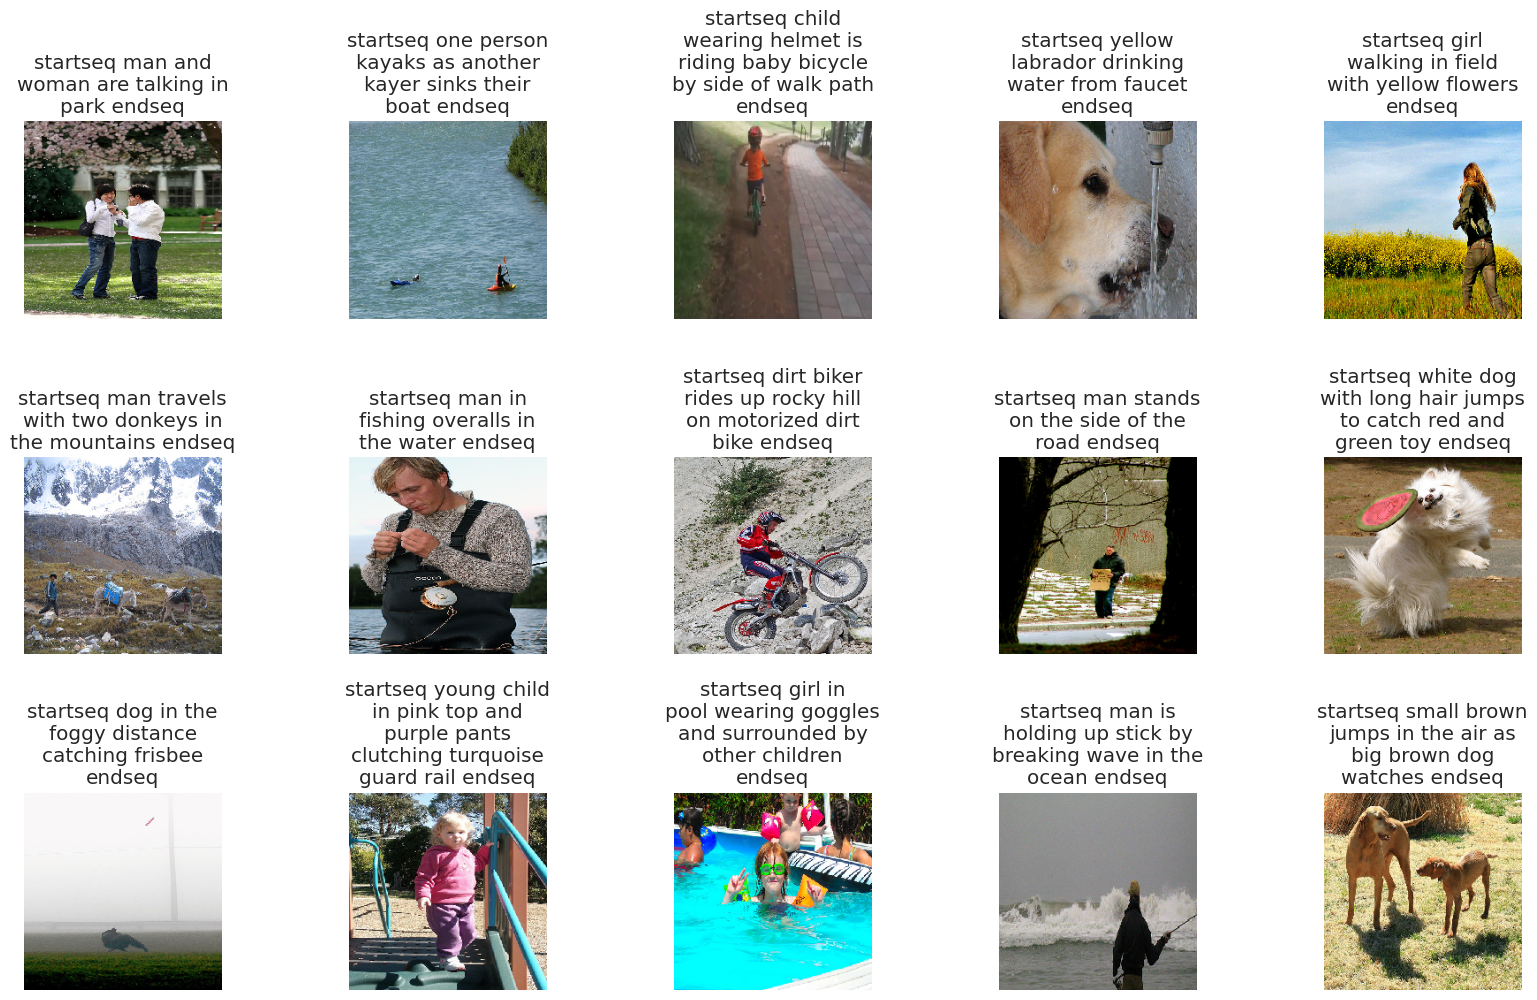

In [55]:
display_images(samples)